# 05c Parameter Optimisation

> Minimise a variety of objective functions to find the optimal parameters for different error models 

In [1]:
#|default_exp core.05c_parameter_optimisation

In [2]:
#|hide
from nbdev.showdoc import show_doc

In [3]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/03a_explore_datasets.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [4]:
#|export
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize
import scipy.stats as stat
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

from fastcore.test import *

from dementia_inequalities import const, log, utils, tools 

In [5]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

Josefin Sans font set for Matplotlib.
mplstyle activated.


y_pred_all_GP

In [6]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [7]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.054537,41.277676,29.459719,51.924546,16.393357,5.298762,2.534370,186.084815,0.105584
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.520773,57.864140,16.212434,51.872532,8.334167,2.933158,1.034842,437.450820,0.224167
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.757572,45.298420,19.513040,51.475795,11.160066,3.982729,1.633168,124.734713,0.107840
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.864371,46.247977,20.734161,51.097420,11.826167,4.774197,1.863024,442.084950,0.311082
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.658556,39.900936,24.100070,51.143136,13.049211,5.147664,1.839612,78.032656,0.093811


In [8]:
#|export
# The real dementia x and y data 

# covariates 
covar = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'GP_LAD_pc']

# Input data 
x = np.array(df_dem_plus[covar].values.reshape(-1,len(covar)))

# Outcome data 
y = np.array(df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1))

### Optimise the negative log likelihood 

We evaluate the log-likelihood using the maximise function from scikit-learn. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the reflected & shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

The reflected & shifted log-normal PDF at $x$ is: 

$$
p(x|x<\delta, \delta, \mu, \sigma) = 
\frac{1}{(\delta - x)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\delta - x)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 
- $\delta$ is the shift parameter - here the shift is the linear equation: $\delta = \beta X$.

Since, we are taking $y_i$ to represent the observed diagnoses, and $\beta X$ to represent the expected a lower bound on the true prevalence rate we have:  

$$
y_i=\beta X_i - \epsilon 
$$ 

Where $\epsilon > 0$. 

We can visualise what the reflected & shifted log normal looks like:




In [9]:
#|export
# NOTE this is just the function to use for plotting 
def reverse_shift_log_normal_pdf(x, delta, mu, sigma):
    pdf = []
    for i, x_i in enumerate(x):
        if delta[i] < x_i: 
            pdf.append(0)
        else: 
            x_shift = delta[i] - x_i
            norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
            exp_part = np.exp(-1 * (1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
            pdf.append(norm_const.squeeze() * exp_part.squeeze())
            
    return np.array(pdf)

def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_87354/3761313376.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_87354/3761313376.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  pdf.append(norm_const.squeeze() * exp_part.squeeze())


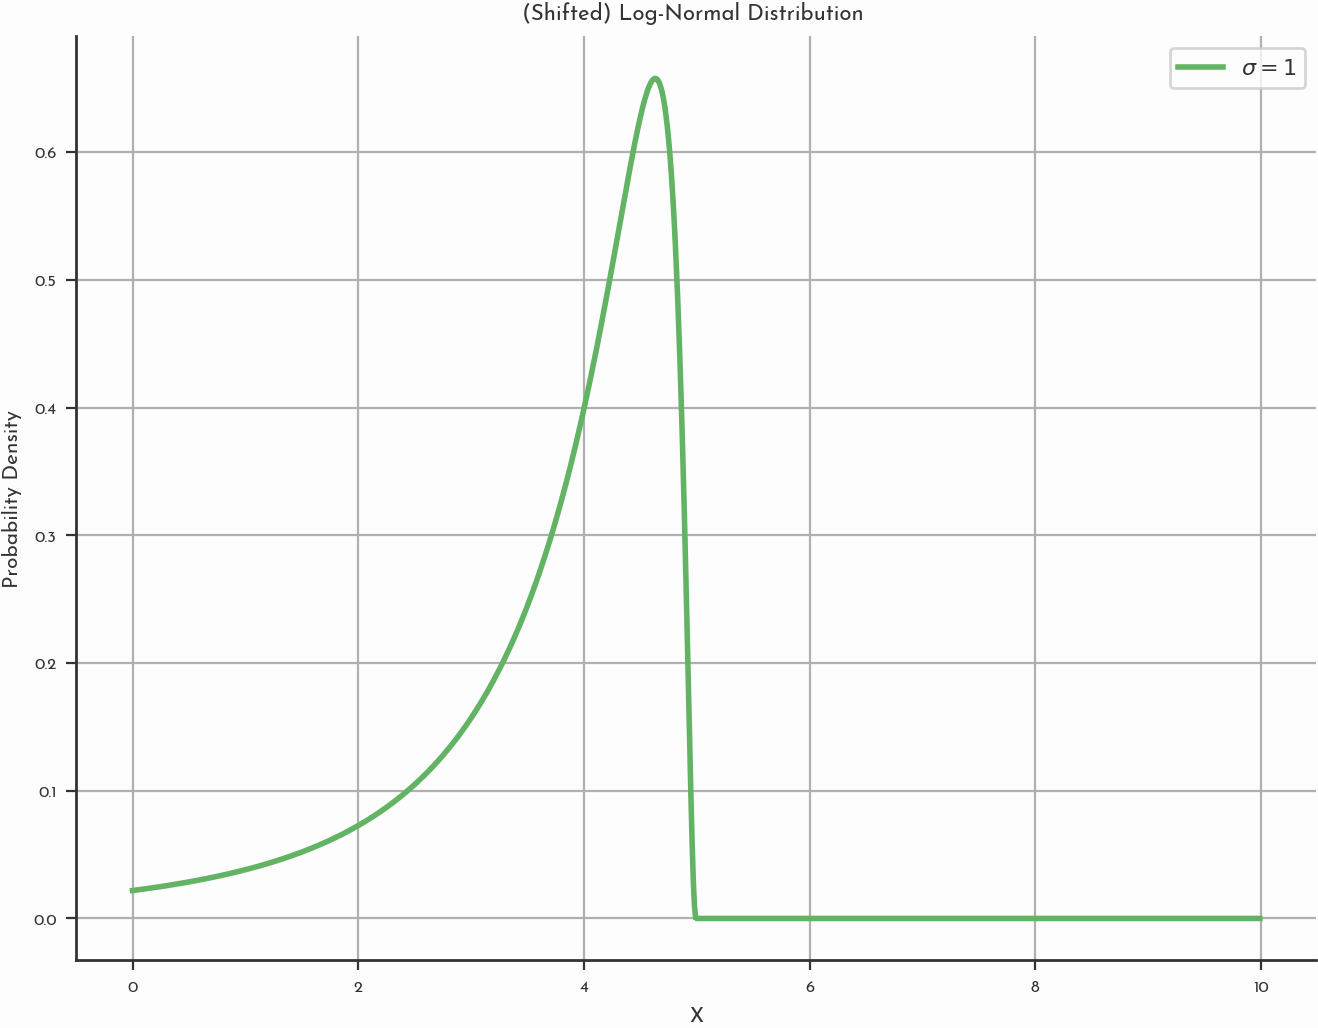

In [10]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
sigma_0 = 1
shift = 5 # Shift 

x_axis = np.arange(0, 10, 0.01)
shift = shift * np.ones(len(x_axis))

pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, shift, mu_0, sigma_0)

# Plot the log-normal probability density function (PDF)
plt.figure(figsize=(8,6), dpi=200)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='xkcd:boring green', label='$\sigma=1$')

plt.title('(Shifted) Log-Normal Distribution ')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

Now, accordingly the probability of a datapoint being distributed according to this log-normal error is: 

$$
p(y_i|y_i < \beta X_i, \beta, \mu, \sigma) = 
\frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

And hence, the likelihood is: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | y_i < \beta X, \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

Let $ z_i = \beta X_i -y_i $. Then we have a log likelihood of:

$$
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} exp(- \frac{(ln z_i - \mu)^2}{2 \sigma^2})) \\ 
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} ) - \frac{ln^2z_i -2\mu ln z_i + \mu^2}{2 \sigma^2} \\
= \sum_{i=1}^n - ln(z_i \sigma \sqrt{2 \pi}) - \frac{1}{2 \sigma^2}(ln^2z_i -2\mu ln z_i + \mu^2) \\
= \sum_{i=1}^n \frac{1}{2 \sigma^2}(2\mu ln z_i - ln^2 z_i - \mu^2) - ln(z_i \sigma \sqrt{2 \pi}) \\

$$

In [11]:
#|export

def log_rvs_shift_log_normal(z, # random variable
                             delta, # the shift parameter
                             mu, # mean of the logarithm of z
                             sigma # standard deviation of the logarithm of z
                             ):
    "Returns the logarithm of the reverse, shifted, log normal probability density function."
    pdf = []
    z_shift = np.array(delta - z)
    for i in range(len(z_shift)):
        if z_shift[i]>0: 
            part1 = (1/(2 * sigma ** 2)) * (2 * mu * np.log(z_shift[i]) - (np.log(z_shift[i])) ** 2 - mu ** 2) 
            part2 = np.log(z_shift[i] * sigma * np.sqrt(2 *np.pi))
            pdf.append(part1 - part2)
        else:
            pdf.append(-np.inf) # returns -inf at the points where the log normal is undefined 
    return np.array(pdf)

def neg_loglike(params, # parameters to optimise
                x, # independent variables 
                y # dependent variables 
                ):
    "Returns the negative log likelihood"
    beta_0 = params[0]
    beta = np.array(params[1:-2])
    mu = params[-2]
    sigma = params[-1]

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    log_likely = log_rvs_shift_log_normal(y.squeeze(), delta=y_pred.squeeze(), mu=mu, sigma=sigma)
    
    return (-1 * np.sum(log_likely)).squeeze()

In [12]:
trial_params = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, 0.0, 0.25])
test_close(neg_loglike(trial_params, x, y), 344.64, eps=0.1)

jacobian_ = jacobian(neg_loglike)
jac_test1 = [1178.27, 26661.43, 60133.66, 46470.22, 103729.9, 139.77, -1568.54, -1892.12]
test_close(jacobian_(trial_params, x, y), jac_test1, eps=0.1)

## Some slightly unexpected behaviour here 

So, something odd happens here, for certain parameter values the negative log likelihood is positive. This is because the log-normal-pdf can be greater than 1, since it's a continous probability distribution it's only bound in that it's integral =1. As a result, for sharply peaked log normals (when both $\mu$ and $\sigma$ are small) we have $x$ values for which $p(x|\mu, \sigma)$ >1, and hence we end up with $- \sum log(p(x|\mu, \sigma))<0$. 

See this example:

In [13]:
params_practise = [8.755e-01,  1.605e-02, -1.870e-03,  5.155e-04, -3.925e-04, 2.349e-02, -2.423e-01,  1.215e-01]
print(f'negative log likelihood: {neg_loglike(params_practise, x, y)}')

delta_shift = np.dot(x, params_practise[1:-2])
print(f'The product of the probabilities: {np.prod(reverse_shift_log_normal_pdf(y, delta_shift, -2.423e-01,  1.215e-01))}')

negative log likelihood: 3510.5178051505304
The product of the probabilities: 0


A few checks with simpler examples that the function returns the values we expect

In [14]:
x_practise1 = np.array([[1, 1.5], [2, 3.5]])
y_practise1 = np.array([0, 0])
params_practise1 = np.array([1, 2, 3, 0, 0.5])

test_close(neg_loglike(params_practise1, x_practise1, y_practise1), 28.3, eps=0.1)

In [15]:
x_practise2 = np.array([[7, 5], [7, 6]])
y_practise2 = np.array([0, 2])
params_practise2 = np.array([0, 0, 2, 1, 0.5])

test_close(neg_loglike(params_practise2, x_practise2, y_practise2), 11.8, eps=0.1)

jacobian_ = jacobian(neg_loglike)
jac_test2 = [1.2, 8.6, 6.8, -10.4, -23.1]
test_close(jacobian_(params_practise2, x_practise2, y_practise2), jac_test2, eps=0.1)

## Using scipy minimize 

Now we use `scipy.minimize` in order to optimise the function. We are using minimize with the negative of the likelihood which should always be positive.

We can initialise from a random point:

In [16]:
# n_features = 7
# np.random.seed(27)
# params_0 = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]]) 

Or, we initialise from a point near to where we expect the minimum to be (based on the multiple linear regression coefficients):

In [17]:
params_0 = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, 0.1, 0.25])

There are different methods to optimise, such as Nelder-Mead - which doesn't use the functions derivative.

In [18]:
# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(neg_loglike, x0=params_0, args=(x,y), method = 'Nelder-Mead')

In [19]:
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -340.7490774493841
             x: [-2.722e-01  2.724e-02  2.779e-02 -6.651e-04  1.014e-03
                  1.584e-01  1.201e-01  7.124e-02]
           nit: 926
          nfev: 1387
 final_simplex: (array([[-2.722e-01,  2.724e-02, ...,  1.201e-01,
                         7.124e-02],
                       [-2.722e-01,  2.723e-02, ...,  1.201e-01,
                         7.124e-02],
                       ...,
                       [-2.723e-01,  2.724e-02, ...,  1.201e-01,
                         7.124e-02],
                       [-2.723e-01,  2.724e-02, ...,  1.201e-01,
                         7.124e-02]]), array([-3.407e+02, -3.407e+02, -3.407e+02, -3.407e+02,
                       -3.407e+02, -3.407e+02, -3.407e+02, -3.407e+02,
                       -3.407e+02]))


Or a method like BFGS which uses the first derivative:

In [20]:
#derivates of neg_loglike
# jacobian_  = jacobian(neg_loglike)

# result = minimize(neg_loglike, x0=params_0, args=(x,y), method='BFGS', jac = jacobian_, options={'gtol': 1e-6, 'disp':True})
# result

In [21]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-2]
MLE_mu = MLE_params[-2]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Mu:", MLE_mu)
print("Sigma:", MLE_sigma)

MLE estimates 
--------------
--------------
Intercept:-0.27221513749140114
--------------
Regression coefficients
--------------
over_65_pc:0.0272352042724196
female_pc:0.027786162016409256
ALevel_plus_pc:-0.0006651332262950396
white_pc:0.0010144739174956928
GP_LAD_pc:0.15836291664973529
--------------
Log normal coefficients
--------------
Mu: 0.12009636563799896
Sigma: 0.07124171472765442


In [22]:
print(f'At the MLE, the negative loglikelihood is: {neg_loglike(MLE_params, x, y)}')

At the MLE, the negative loglikelihood is: -340.7490774493841


And we can plot the shape of the log normal

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


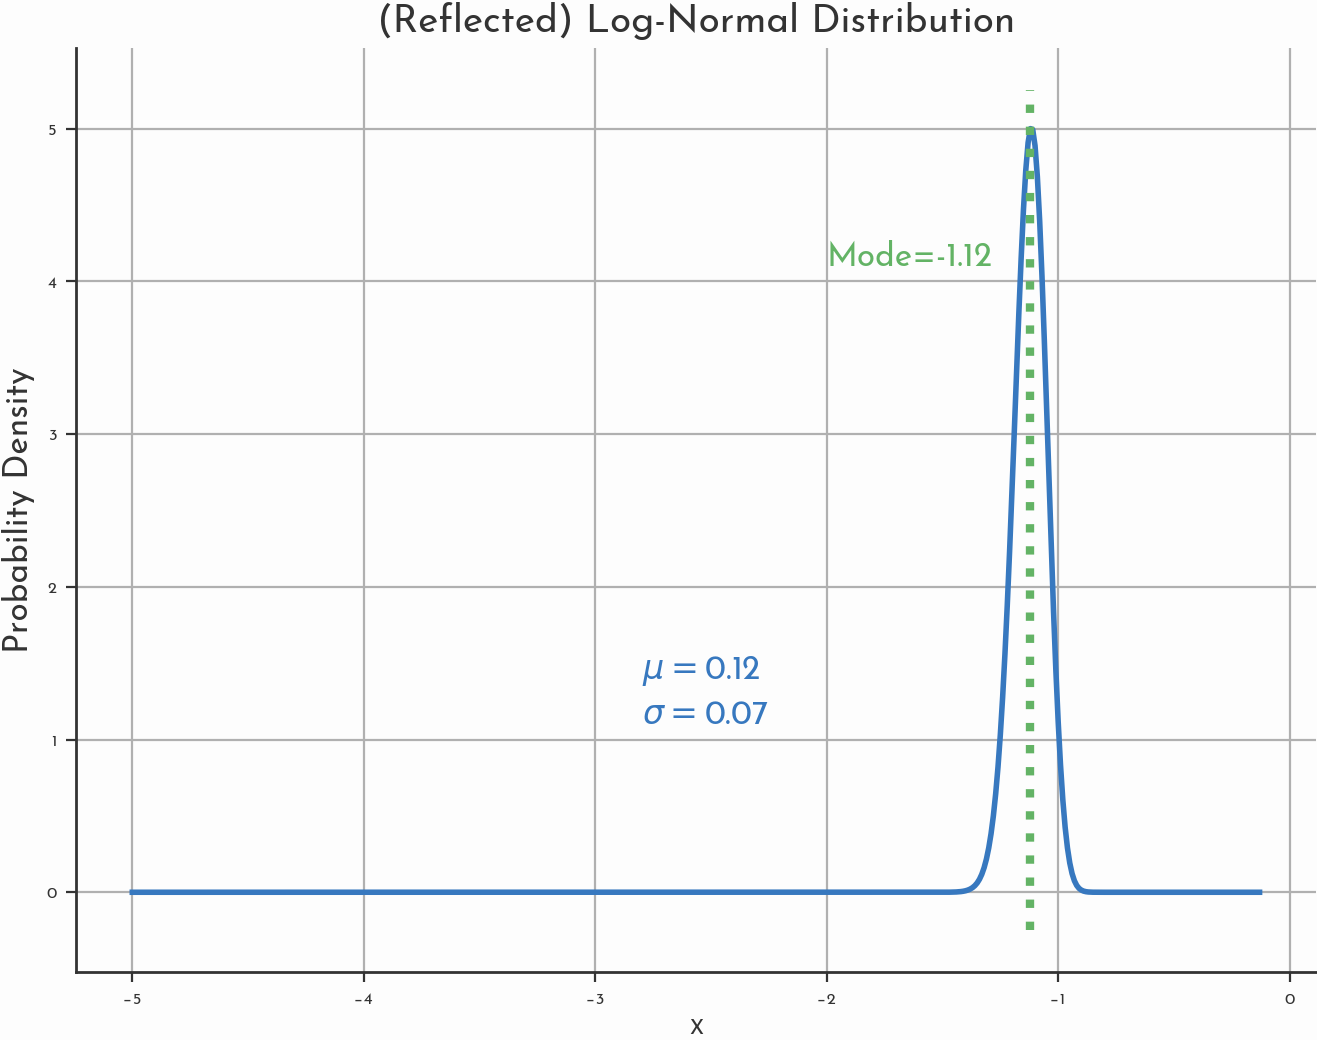

In [23]:
# mode of the log normal 
plt.figure(figsize=(8,6), dpi=200)
mode = log_norm_mode(MLE_mu, MLE_sigma)

# plot log normal of MLE parameters 
x_axis = np.arange(-5, 0, 0.01)
pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, np.zeros(len(x_axis)), MLE_mu, MLE_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='xkcd:windows blue')
plt.text(-2.8, 1.1, f'$\sigma=${np.round(MLE_sigma, 2)}', color='xkcd:windows blue', size=12)
plt.text(-2.8, 1.4, f'$\mu=${np.round(MLE_mu, 2)}', color='xkcd:windows blue', size=12)

ymin, ymax = plt.ylim()
plt.vlines(-mode, ymin, ymax, color='xkcd:boring green', label='Log normal mode', linestyles='dotted')
plt.text(-2, 4.1, f'Mode={np.round(-mode,2)}', color='xkcd:boring green', size=12)

plt.title('(Reflected) Log-Normal Distribution', size=14)
plt.xlabel('X')
plt.ylabel('Probability Density', size=12)
plt.grid(True)

plt.savefig(const.figs_path+'/mle_reflected_log_normal.png')
plt.show()

### Save the results predicted by the model as a .csv 

In [24]:
# The values predicted by the linear regression - conceptually this should be the "true" dementia prevalence rates 
y_pred = np.dot(x, MLE_beta.T) + MLE_intercept
df_dem_plus['log_norm_model_pred'] = y_pred

diagnosis_gap = y.squeeze() - y_pred.squeeze()
df_dem_plus['diagnosis_gap']=diagnosis_gap

df_dem_plus.to_csv(const.output_path+'/log_norm_model/log_norm_model_results.csv')

And subsquently look at those regions with the largest gap from the regression line - conceptually those with the worst diagnosis rates

In [25]:
most_bad_lads = np.argsort(diagnosis_gap)[-10:]
df_dem_plus.iloc[most_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
196,East Hampshire,-0.962845
3,Lancaster,-0.955487
189,Gateshead,-0.947568
10,Southend-on-Sea,-0.945035
272,Gosport,-0.940483
123,Surrey Heath,-0.938303
29,East Devon,-0.937195
63,Eastbourne,-0.916604
225,Southampton,-0.884937
77,Rochford,-0.861372


And those regions with the smallest gap - conceptually those with the best diagnosis rates

In [26]:
least_bad_lads = np.argsort(diagnosis_gap)[:10]
df_dem_plus.iloc[least_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
40,South Hams,-1.355309
271,Eden,-1.303135
288,Plymouth,-1.293384
274,Thanet,-1.291947
257,South Cambridgeshire,-1.287858
263,Eastleigh,-1.276474
37,Medway,-1.276291
55,Isles of Scilly,-1.275464
60,Worcester,-1.275106
276,Fenland,-1.273727


## Evaluate the hessian at the MLE 

We can look at the Hessian evaluated at the MLE.

In [27]:
def is_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [28]:
hessian_ = hessian(neg_loglike)

# check if it is positive definite
is_def(hessian_(MLE_params, x, y))

True

## Alternative model using a half normal distribution instead 

In [29]:
# Negative log likelihood for the half normal distribution 

# Define functions to minimize
def neg_loglike_half_norm(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:-1])
    sigma = params[-1]

    log_pdf = []
    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    y = y.reshape(1, len(x)).squeeze()

    z_shift = np.array(y_pred-y)

    for i in range(len(z_shift)):
        if z_shift[i]>0:
            normalising = 1/(sigma* np.sqrt(2*np.pi))
            exp_part = np.exp(-(1/2)*(z_shift[i]/sigma)**2)
            log_pdf.append(np.log(normalising*exp_part))
        else:
            log_pdf.append(-np.inf)

    return np.array(-1 * np.sum(log_pdf))

In [30]:
# Values to initialise from 
params_0 = np.array([-1, 0.02, 0.02, 0.001, 0.001, 0.1])
sigma_0 = 0.2

In [31]:
# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(neg_loglike_half_norm, x0=np.append(params_0, sigma_0), args=(x,y), method = 'Nelder-Mead')

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/optimize/_optimize.py:941: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


In [32]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-1]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Sigma:", MLE_sigma)

MLE estimates 
--------------
--------------
Intercept:-1.0
--------------
Regression coefficients
--------------
over_65_pc:0.02
female_pc:0.02
ALevel_plus_pc:0.001
white_pc:0.001
GP_LAD_pc:0.1
--------------
Log normal coefficients
--------------
Sigma: 0.2


/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


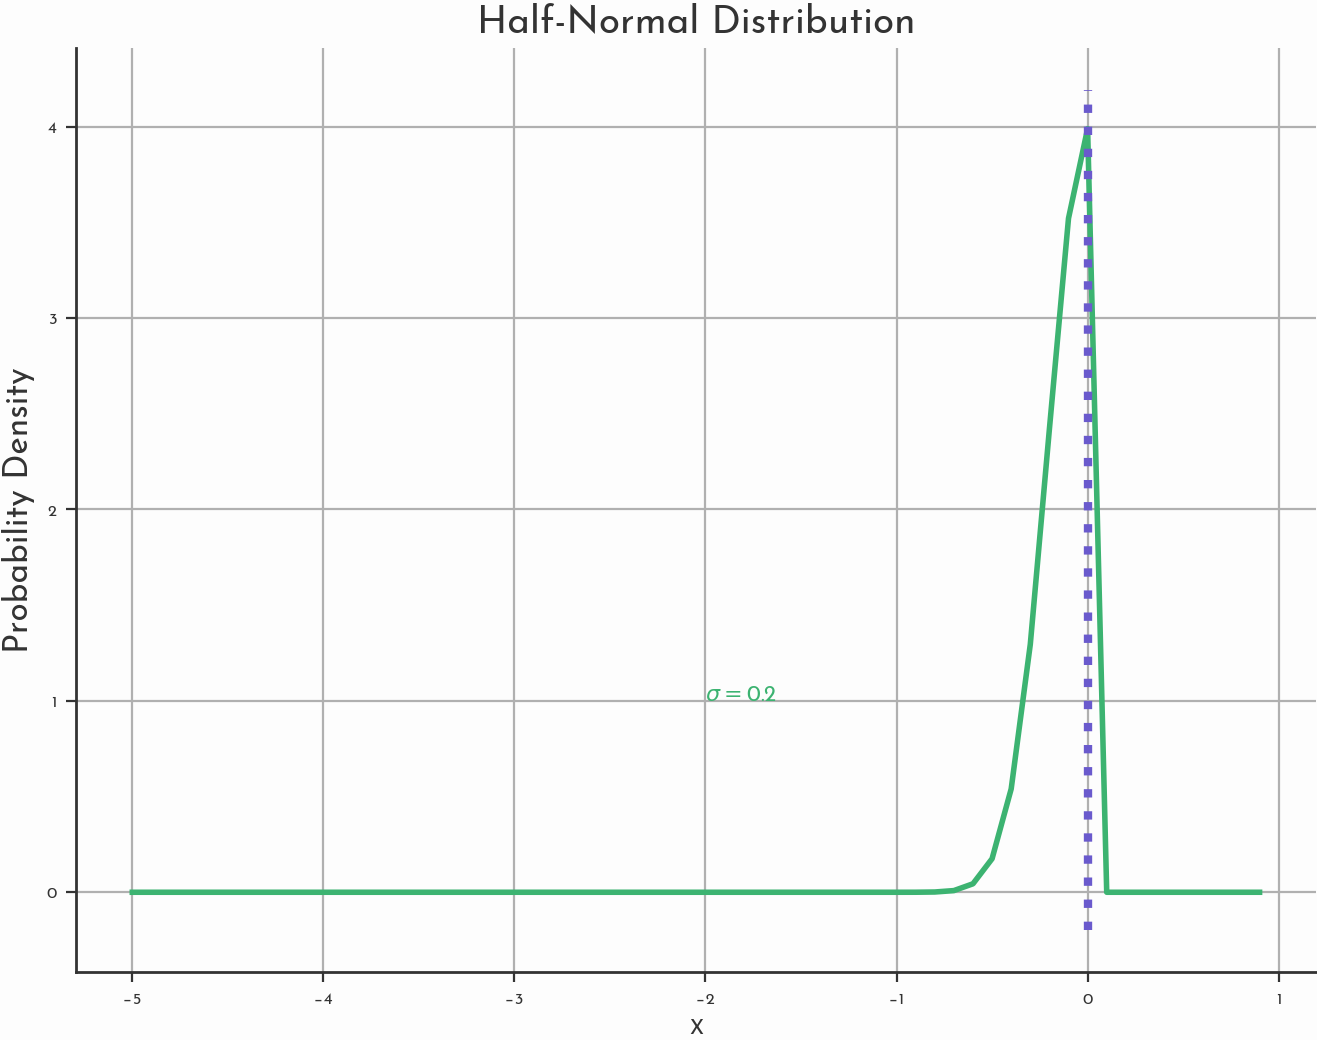

In [33]:
# Plot the half normal distribution from the model 

plt.figure(figsize=(8,6), dpi=200)

# plot log normal of MLE parameters 
x_axis = np.arange(-5,1, 0.1)
pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, np.zeros(len(x_axis)), MLE_mu, MLE_sigma)

halfnorm_pdf = stat.halfnorm.pdf(-x_axis, scale=MLE_sigma)
plt.plot(x_axis, halfnorm_pdf, '-', linewidth=2, color='mediumseagreen')
plt.text(-2, 1, f'$\sigma=${np.round(MLE_sigma, 3)}', color='mediumseagreen')
ymin, ymax = plt.ylim()
plt.vlines(0, ymin, ymax, color='slateblue', linestyles='dotted')

plt.title('Half-Normal Distribution', size=14)
plt.xlabel('X')
plt.ylabel('Probability Density', size=12)
plt.grid(True)

plt.show()

### And again save the results 

In [34]:
# The values predicted by the linear regression - conceptually this should be the "true" dementia prevalence rates 
y_pred = np.dot(x, MLE_beta.T) + MLE_intercept
df_dem_plus['half_norm_model_pred'] = y_pred

diagnosis_gap = y.squeeze() - y_pred.squeeze()
df_dem_plus['half_norm_diagnosis_gap']=diagnosis_gap

df_dem_plus.to_csv(const.output_path+'/half_norm_model/half_norm_model_results.csv')

In [35]:
df_dem_plus['half_norm_diagnosis_gap']

0      0.281815
1      0.015793
2      0.197513
3      0.262584
4      0.010610
         ...   
304    0.101832
305    0.077991
306   -0.001248
307    0.154363
308    0.032768
Name: half_norm_diagnosis_gap, Length: 309, dtype: float64

## Check the model by implementing a linear regression. 

Create a function which we apply `scipy.minimize` to in order ot find the MLE parameters. This code be done using two different objective functions - either:
1. Ordinary least squares (OLS) - based on the assumption that the error is gaussian the MLE parameters of the regression line minimize the OLS function (which is just the sum of the differences squared). 
2. Gaussian error - based on the assumtpion that the error term is gaussian we can minimize the negative log likelihood of the observed data, given a mean of the regression line, and some standard deviation sigma, which is fit as part of the model. 

In [36]:
# Define functions to minimize

# OLS
def linear_log_ols(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:])

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    y = y.reshape(1, len(x)).squeeze()
    squares = (y_pred-y)**2
    
    return (np.sum(squares)).squeeze()

# ALTERNATIVE FUNCTION - which uses the equation for the gaussian pdf
# Define functions to minimize
def linear_neg_loglike(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:-1])
    sigma = params[-1]

    log_pdf = []
    y_pred = (np.dot(x, beta)).squeeze() + beta_0

    z_shift = np.array(y_pred-y)

    for i in range(len(z_shift)):
        normalising = 1/(sigma* np.sqrt(2*np.pi))
        exp_part = np.exp(-(1/2)*(z_shift[i]/sigma)**2)
        log_pdf.append(np.log(normalising*exp_part))

    return np.array(-1 * np.sum(log_pdf))

In [37]:
# Values to initialise from 
params_0 = np.array([0.1, 0.01, 0.004, -0.004, -0.003, 0.01])
sigma_0 = 0.2

# the MLE parameters from the multiple linear regression using sklearn 
regr_coeff = np.load(const.pre_output_path+'/reg_coeff.npy')

In [38]:
# Check the function works by evaluating at a certain point 
linear_neg_loglike(np.append(params_0, sigma_0),x, y)

array(299377.46994219)

In [39]:
# Calculate the gradient at this point 
grad_loglike = grad(linear_neg_loglike)
grad_loglike(np.append(np.array(regr_coeff), 0.1), x, y)

array([ 3.17049853e-09,  7.29179675e+06,  2.40535437e+05, -2.83761317e+06,
        2.34414608e+07, -2.43154028e+03, -4.17639607e+06])

In [40]:
# Inspect the Hessian at this point 
hessian_ = hessian(linear_neg_loglike)
print(f'Hessian eigenvalues: {np.linalg.eigvals(hessian_(np.append(np.array(regr_coeff), 0.1), x, y))}')
print(f'Hessian matrix positive definite: {is_def(hessian_(np.append(np.array(regr_coeff), 0.1), x, y))}')

Hessian eigenvalues: [1.05708801e+11 1.89745761e+09 1.86705873e+08 1.10747525e+08
 3.31669409e+07 1.56661789e+03 2.97671446e+04]
Hessian matrix positive definite: True


In [41]:
# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(linear_log_ols, x0=params_0, args=(x,y), method = 'Nelder-Mead')

print(result)

# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:]

print("MLE estimates (OLS model)\n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.933968585696655
             x: [-9.691e-01  2.735e-02  1.955e-02 -8.609e-04  8.710e-04
                  1.872e-01]
           nit: 554
          nfev: 871
 final_simplex: (array([[-9.691e-01,  2.735e-02, ...,  8.710e-04,
                         1.872e-01],
                       [-9.690e-01,  2.735e-02, ...,  8.709e-04,
                         1.872e-01],
                       ...,
                       [-9.690e-01,  2.735e-02, ...,  8.709e-04,
                         1.872e-01],
                       [-9.691e-01,  2.735e-02, ...,  8.709e-04,
                         1.872e-01]]), array([ 1.934e+00,  1.934e+00,  1.934e+00,  1.934e+00,
                        1.934e+00,  1.934e+00,  1.934e+00]))
MLE estimates (OLS model)
--------------
--------------
Intercept:-0.969065470994887
--------------
Regression coefficients
--------------
over_65_pc:0.02735206069180662
female_

In [42]:
params_01 = np.append(regr_coeff, sigma_0)

# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(linear_neg_loglike, x0=params_01, args=(x,y), method = 'Nelder-Mead')

result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -31931.774939013965
             x: [ 6.270e-01 -3.104e-07  4.936e-07  2.751e-08  8.950e-08
                  2.185e-05  1.732e-01]
           nit: 899
          nfev: 1355
 final_simplex: (array([[ 6.270e-01, -3.104e-07, ...,  2.185e-05,
                         1.732e-01],
                       [ 6.270e-01, -4.332e-07, ...,  8.307e-06,
                         1.732e-01],
                       ...,
                       [ 6.271e-01,  4.573e-07, ...,  1.462e-05,
                         1.732e-01],
                       [ 6.270e-01, -2.060e-07, ...,  1.476e-05,
                         1.732e-01]]), array([-3.193e+04, -3.193e+04, -3.193e+04, -3.193e+04,
                       -3.193e+04, -3.193e+04, -3.193e+04, -3.193e+04]))

In [43]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-1]
MLE_sigma = MLE_params[-1]

print("MLE estimates (Gaussian model)\n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nGaussian standard deviation\n--------------")
print("Sigma:", MLE_sigma)

MLE estimates (Gaussian model)
--------------
--------------
Intercept:0.6270284013940928
--------------
Regression coefficients
--------------
over_65_pc:-3.103881297234349e-07
female_pc:4.936357578522903e-07
ALevel_plus_pc:2.750652825994351e-08
white_pc:8.950136111427524e-08
GP_LAD_pc:2.1845864842894377e-05
--------------
Gaussian standard deviation
--------------
Sigma: 0.17318999627754034


In [44]:
# Calculate the gradient at this point 
grad_loglike = grad(linear_neg_loglike)
grad_loglike(np.array(MLE_params), x, y)

array([-0.10242371, -6.01335167, -4.7488914 ,  3.89747805,  4.79054859,
        0.2234384 ,  3.48636278])

In [45]:
# Inspect the Hessian at this point 
hessian_ = hessian(linear_neg_loglike)
print(f'Hessian eigenvalues: {np.linalg.eigvals(hessian_(np.array(MLE_params), x, y))}')
print(f'Hessian matrix positive definite: {is_def(hessian_(np.array(MLE_params), x, y))}')

Hessian eigenvalues: [3.52419817e+10 6.12111960e+08 5.91924234e+07 2.38032107e+07
 5.41161424e+02 9.97338911e+03 6.36644848e+06]
Hessian matrix positive definite: True
